In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_dir = "/content/drive/MyDrive/AI_Assignment1/pest/train"
test_dir = "/content/drive/MyDrive/AI_Assignment1/pest/test"

In [3]:
# Save and load Python objects (e.g., models, tokenizers, etc.)
import pickle

# Numerical computing library (arrays, mathematical operations)
import numpy as np

# Deep learning framework used for building and training neural network models
import tensorflow as tf

# Visualization library to make attractive and informative statistical graphics
import seaborn as sns

# Interact with the operating system (e.g., file paths, directory creation)
import os

# Used to measure training time, performance tracking, or setting time-based conditions
import time


In [4]:
# For loading, preprocessing, and augmenting image data during model training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For evaluating model performance (generates classification report and confusion matrix)
from sklearn.metrics import classification_report, confusion_matrix

# To handle imbalanced datasets by calculating class weights
from sklearn.utils.class_weight import compute_class_weight

# Callback functions: EarlyStopping stops training early if no improvement, ReduceLROnPlateau reduces learning rate when a metric has stopped improving
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# To define the CNN model architecture sequentially (layer-by-layer)
from tensorflow.keras.models import Sequential

# Essential layers for building CNN models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# For applying regularization (e.g., L2 regularization) to avoid overfitting
from tensorflow.keras import regularizers

# For image file handling and error catching if corrupted or invalid image files are encountered
from PIL import Image, UnidentifiedImageError


In [5]:
train_classes = sorted(os.listdir(train_dir))
test_classes = sorted(os.listdir(test_dir))
if not train_classes:
  print("No class directories found in the train folder")
else:
  print(f"Found {len(train_classes)} classes: {train_classes}")

Found 9 classes: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


In [6]:
# Function to clean corrupted images from a given directory
def clean_corrupted_images(directory):
    print(f"\nChecking: {directory}")  # Print the directory being checked
    deleted_count = 0  # Counter to keep track of how many images are deleted

    # Loop through each class folder inside the directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)

        if os.path.isdir(class_path):
            # Loop through each image inside the class folder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    # Try to open and verify if the image is not corrupted
                    with Image.open(img_path) as img:
                        img.verify()
                except (IOError, UnidentifiedImageError) as e:
                    # If error occurs, it means the image is corrupted
                    print(f"Deleting corrupted image: {img_path} - Reason: {e}")
                    os.remove(img_path)  # Delete the corrupted image
                    deleted_count += 1

    # Summary of action
    if deleted_count == 0:
        print("No corrupted images found.")
    else:
        print(f"Done. Deleted {deleted_count} corrupted image(s).")

# Example usage: Run cleaning for train and test directories
clean_corrupted_images(train_dir)
clean_corrupted_images(test_dir)



Checking: /content/drive/MyDrive/AI_Assignment1/pest/train
No corrupted images found.

Checking: /content/drive/MyDrive/AI_Assignment1/pest/test
No corrupted images found.


In [7]:
# Function to count the number of images per class in a directory
def count_images_per_class(base_dir, class_names):
    image_counts = {}  # Dictionary to store image count per class
    total = 0  # Variable to store total number of images

    # Loop through each class
    for cls in class_names:
        class_path = os.path.join(base_dir, cls)

        # Count the number of image files in the class directory
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))
        ])

        image_counts[cls] = num_images  # Store count for this class
        total += num_images  # Update total image count

    return image_counts, total  # Return the dictionary and total images

# Get class names from training and testing directories
train_classes = sorted(os.listdir(train_dir))
test_classes = sorted(os.listdir(test_dir))

# Count images in each class for train and test sets
train_counts, total_train = count_images_per_class(train_dir, train_classes)
test_counts, total_test = count_images_per_class(test_dir, test_classes)

# Collect all unique class names from both train and test directories
# (In case some classes exist in train but not test or vice-versa)
all_classes = sorted(set(train_counts.keys()) | set(test_counts.keys()))

# Print header
print("Images per Class")
print("=" * 59)
print(f"{'Class Name':<30}{'Train Images':>15}{'Test Images':>15}")
print("=" * 59)

# Print image count for each class
for cls in all_classes:
    train_num = train_counts.get(cls, 0)  # Get number of train images for class
    test_num = test_counts.get(cls, 0)    # Get number of test images for class
    print(f"{cls:<30}{train_num:>15}{test_num:>15}")

# Print totals
print("=" * 59)
print(f"{'Total training images:':<30}{total_train}")
print(f"{'Total testing images:':<30}{total_test}")
print(f"{'Total images:':<30}{total_train + total_test}")


Images per Class
Class Name                       Train Images    Test Images
aphids                                    266             44
armyworm                                  228             43
beetle                                    291             50
bollworm                                  245             36
grasshopper                               287             46
mites                                     254             42
mosquito                                  315             50
sawfly                                    200             37
stem_borer                                181             36
Total training images:        2267
Total testing images:         384
Total images:                 2651


In [8]:
#Define image size and batch size
IMG_HEIGHT, IMG_WIDTH = 150, 150
IMG_CHANNELS =3
BATCH_SIZE =32

In [9]:
# Create an ImageDataGenerator object with enhanced data augmentation techniques
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values from [0, 255] to [0, 1] for faster and more stable training
    rotation_range=20,  # Randomly rotate images by up to 20 degrees to improve rotational invariance
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% to simulate off-centered objects
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% to simulate different vertical positioning
    horizontal_flip=True,  # Randomly flip images horizontally to make the model invariant to direction
    zoom_range=0.2,  # Randomly zoom in/out by up to 20% to make the model robust to scale changes
    shear_range=0.2,  # Apply random shearing transformations (like tilting) to enhance geometric invariance
    validation_split=0.2  # Reserve 20% of the dataset for validation during training
)


In [10]:
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

Found 1816 images belonging to 9 classes.


In [11]:
val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 451 images belonging to 9 classes.


In [12]:
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 384 images belonging to 9 classes.


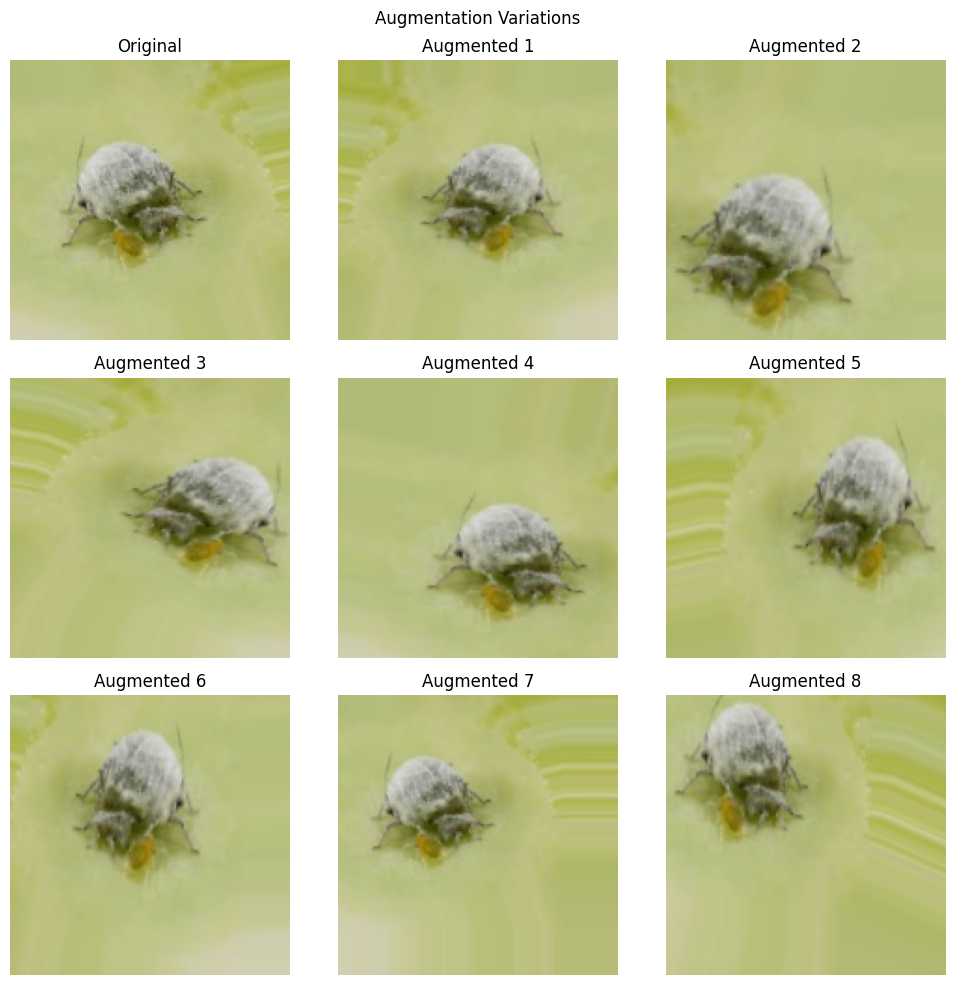

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Visualization-only generator (no rescale)
viz_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

sample_img, _ = next(train_gen)  # Get a batch
img = sample_img[0]

# Convert sample image back to uint8 for visualization
img_uint8 = (img * 255).astype(np.uint8)  # Assuming img was normalized

# Generate augmented images
augmented_images = [img_uint8]
for _ in range(8):
    aug_iter = viz_datagen.flow(np.expand_dims(img_uint8, axis=0), batch_size=1)
    aug_img = next(aug_iter)[0].astype(np.uint8)
    augmented_images.append(aug_img)

# Plotting
plt.figure(figsize=(10, 10))
for i, aug_img in enumerate(augmented_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img)
    plt.axis('off')
    plt.title("Original" if i == 0 else f"Augmented {i}")
plt.suptitle("Augmentation Variations")
plt.tight_layout()
plt.show()


In [14]:
#Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {class_names}")

Number of classes: 9
Class names: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


In [15]:
# Compute class weights ofr imbalanced classes
labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(0.9473135106937924), 1: np.float64(1.1026108075288403), 2: np.float64(0.865999046256557), 3: np.float64(1.0294784580498866), 4: np.float64(0.8772946859903382), 5: np.float64(0.9891067538126361), 6: np.float64(0.800705467372134), 7: np.float64(1.261111111111111), 8: np.float64(1.3915708812260537)}


In [16]:
# Show class distribution
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for cls, count in zip(unique, counts):
    print(f"Class {class_names[int(cls)]}: {count} samples")

Class distribution:
Class aphids: 213 samples
Class armyworm: 183 samples
Class beetle: 233 samples
Class bollworm: 196 samples
Class grasshopper: 230 samples
Class mites: 204 samples
Class mosquito: 252 samples
Class sawfly: 160 samples
Class stem_borer: 145 samples


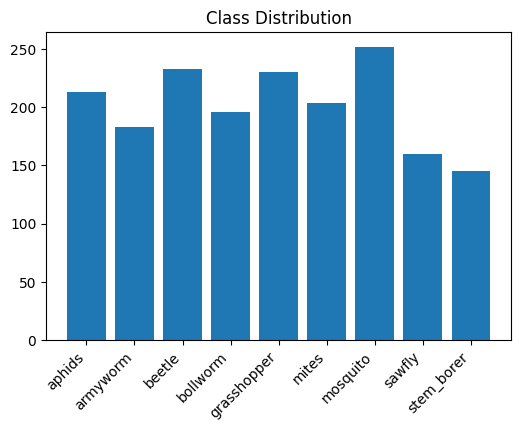

In [17]:
# Plot class distribution
plt.figure(figsize=(6,4))
plt.bar(class_names, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution')
plt.show()


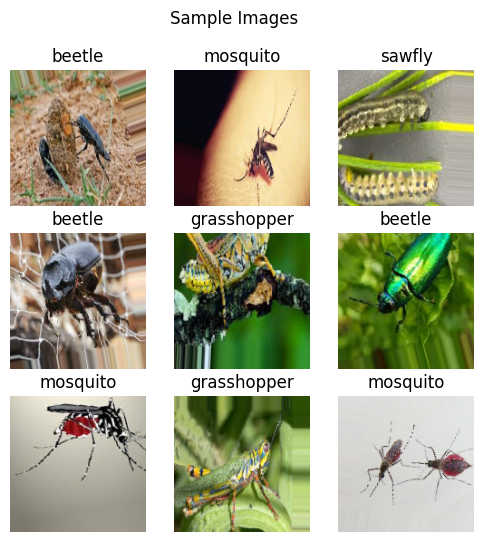

In [18]:
# Display sample images
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(class_names[int(y_batch[i])])  # <-- fix applied here
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()


In [19]:
#Define callbackd for underfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights= True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6 ) # Reduce LR on plateau
]

In [20]:
# Build a baseline CNN model
model_baseline = Sequential([

    # Input layer: Define input shape (height, width, channels)
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),

    # First convolutional block
    Conv2D(32, (3,3), activation='relu'),  # 32 filters of size 3x3, ReLU activation
    MaxPooling2D(),  # Downsample feature maps by taking the max value over 2x2 windows

    # Second convolutional block
    Conv2D(64, (3,3), activation='relu'),  # 64 filters of size 3x3, deeper feature extraction
    MaxPooling2D(),  # Further reduce spatial size and computation

    # Third convolutional block
    Conv2D(128, (3,3), activation='relu'),  # 128 filters, learning even more complex features
    MaxPooling2D(),  # Downsampling again

    # Flatten the output from convolutional layers to feed into dense layers
    Flatten(),

    # Fully connected dense layer
    Dense(128, activation='relu'),  # 128 neurons, learns high-level patterns

    # Output layer for classification
    Dense(NUM_CLASSES, activation='softmax')  # Output probabilities for each class
])


In [21]:
# Compile model
model_baseline.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,513 (18.42 MB)

 Trainable params: 4,829,513 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#Train model
history_baseline = model_baseline.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100, #Increased to address underfitting
    callbacks=callbacks,
    class_weight=class_weights_dict #Handle class imbalance
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 451ms/step - accuracy: 0.1452 - loss: 2.2834 - val_accuracy: 0.2328 - val_loss: 2.0599 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 382ms/step - accuracy: 0.2418 - loss: 2.0436 - val_accuracy: 0.2971 - val_loss: 2.0096 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.2947 - loss: 1.9469 - val_accuracy: 0.2949 - val_loss: 1.8394 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 380ms/step - accuracy: 0.3407 - loss: 1.8325 - val_accuracy: 0.2772 - val_loss: 1.9634 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.4067 - loss: 1.6945 - val_accuracy: 0.3370 - val_loss: 1.8178 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.4509 - loss: 1.5432 - val_accuracy: 0.3459 - val_loss: 1.8061 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.4735 - l

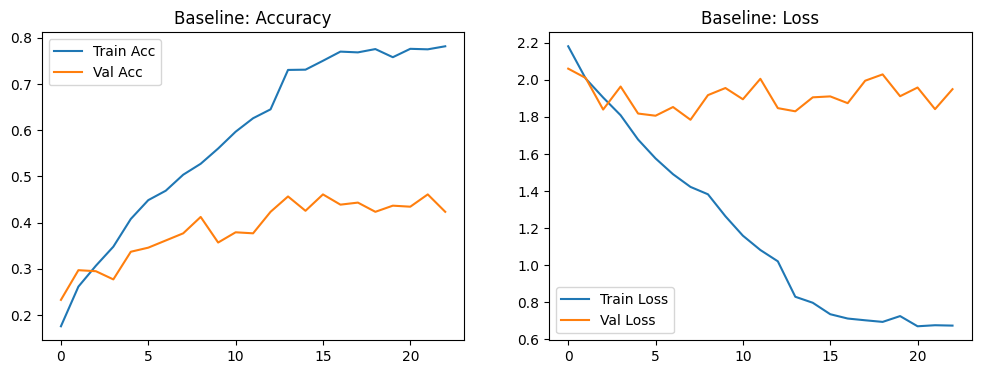

In [23]:
#Plot training & validation accuracy and loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_baseline.history['accuracy'], label='Train Acc')
plt.plot(history_baseline.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Baseline: Accuracy')
plt.subplot(1,2,2)
plt.plot(history_baseline.history['loss'], label='Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Baseline: Loss')
plt.show()

In [24]:
test_loss, test_acc = model_baseline.evaluate(test_gen, verbose=0)
print(f"Baseline Test accuracy: {test_acc:.4f}")

Baseline Test accuracy: 0.4896


In [25]:
y_pred_baseline = model_baseline.predict(test_gen)
y_pred_classes = np.argmax(y_pred_baseline, axis=1)
y_true = test_gen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step
Classification Report:
              precision    recall  f1-score   support

      aphids       0.45      0.61      0.52        44
    armyworm       0.44      0.28      0.34        43
      beetle       0.69      0.58      0.63        50
    bollworm       0.48      0.36      0.41        36
 grasshopper       0.40      0.22      0.28        46
       mites       0.74      0.33      0.46        42
    mosquito       0.81      0.68      0.74        50
      sawfly       0.35      0.51      0.42        37
  stem_borer       0.22      0.53      0.31        36

    accuracy                           0.46       384
   macro avg       0.51      0.46      0.46       384
weighted avg       0.52      0.46      0.47       384



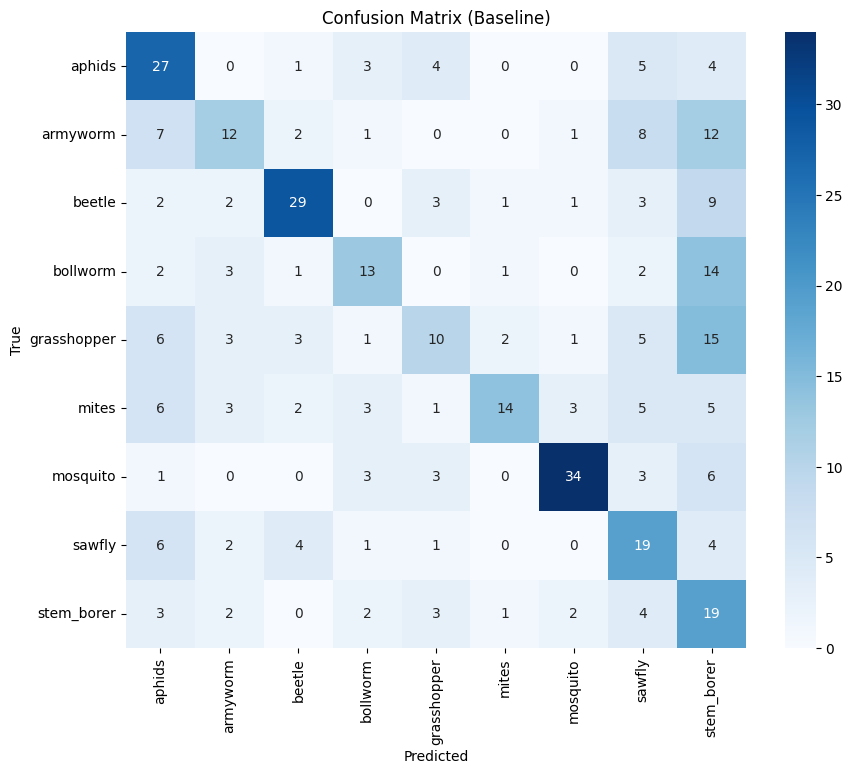

In [26]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Baseline)')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


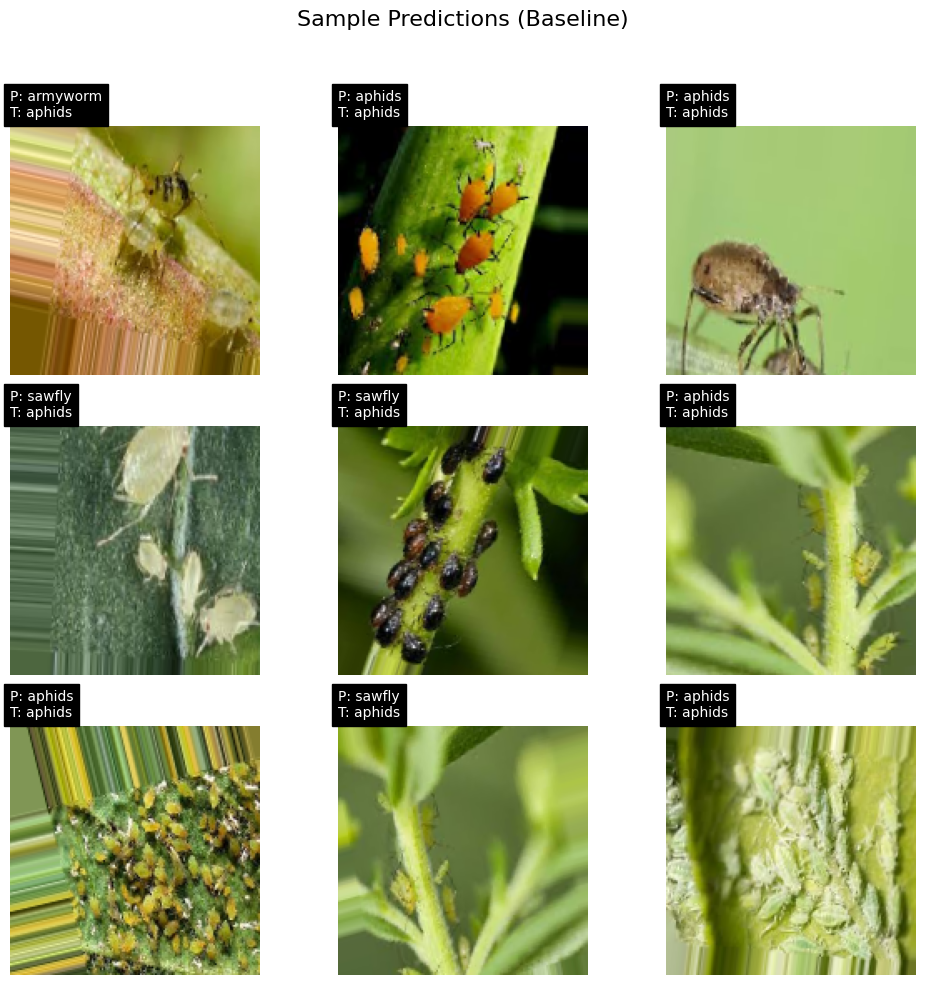

In [27]:
x_test_batch, y_test_batch = next(test_gen)
y_pred_batch = np.argmax(model_baseline.predict(x_test_batch), axis=1)

# Randomly shuffle indices within the batch to display different images each time
random_indices = np.random.permutation(x_test_batch.shape[0])[:9]

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_batch[idx])

    pred_label = class_names[y_pred_batch[idx]]
    true_label = class_names[int(y_test_batch[idx])]

    # Use contrasting text with bounding box for better visibility
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10,
              color='white', backgroundcolor='black', loc='left')
    plt.axis('off')

plt.suptitle("Sample Predictions (Baseline)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [28]:
#Function to builder deeper CNN with tuned regularization
def build_deeper_cnn():
  model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Block 4 (New)
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.35),

        # Classifier
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(NUM_CLASSES, activation='softmax')
    ])
  return model

In [29]:
# Build and compile deeper model
model_deeper = build_deeper_cnn()
model_deeper.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_deeper.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 146, 146, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 69, 69, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,818,089 (10.75 MB)

 Trainable params: 2,815,657 (10.74 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [30]:
epochs = 50
#Train deeper model
start = time.time()
history_deeper = model_deeper.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 57s 677ms/step - accuracy: 0.1702 - loss: 3.0596 - val_accuracy: 0.1109 - val_loss: 3.0706 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy: 0.2894 - loss: 2.3790 - val_accuracy: 0.1397 - val_loss: 3.1063 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - accuracy: 0.3287 - loss: 2.1267 - val_accuracy: 0.0865 - val_loss: 3.5645 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 393ms/step - accuracy: 0.3672 - loss: 1.9709 - val_accuracy: 0.0931 - val_loss: 4.2211 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - accuracy: 0.3986 - loss: 1.9483 - val_accuracy: 0.0998 - val_loss: 4.3522 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step - accuracy: 0.4808 - loss: 1.7066 - val_accuracy: 0.1109 - val_loss: 3.6285 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.4735 - loss: 1.

ValueError: Invalid format specifier ';1f' for object of type 'float'

In [31]:
print(f"Deeper model training time: {time.time() - start:.1f} seconds")


Deeper model training time: 834.1 seconds


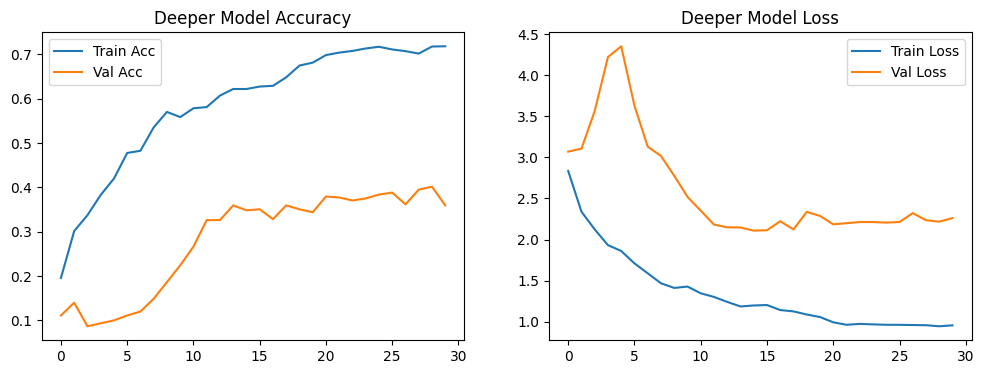

In [32]:
# Plot accuracy/loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_deeper.history['accuracy'], label='Train Acc')
plt.plot(history_deeper.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Deeper Model Accuracy')
plt.subplot(1,2,2)
plt.plot(history_deeper.history['loss'], label='Train Loss')
plt.plot(history_deeper.history['val_loss'], label='Val Loss')
plt.title('Deeper Model Loss')
plt.legend()
plt.show()

In [33]:
test_loss_d, test_acc_d = model_deeper.evaluate(test_gen, verbose=0)
print(f"Deeper Model Test accuracy: {test_acc_d:.4f}")

Deeper Model Test accuracy: 0.5208


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step
Classification Report (Deeper):
              precision    recall  f1-score   support

      aphids       0.63      0.66      0.64        44
    armyworm       0.28      0.53      0.37        43
      beetle       1.00      0.34      0.51        50
    bollworm       0.46      0.44      0.45        36
 grasshopper       0.61      0.41      0.49        46
       mites       0.51      0.79      0.62        42
    mosquito       0.77      0.66      0.71        50
      sawfly       0.64      0.38      0.47        37
  stem_borer       0.44      0.53      0.48        36

    accuracy                           0.53       384
   macro avg       0.59      0.53      0.53       384
weighted avg       0.61      0.53      0.53       384



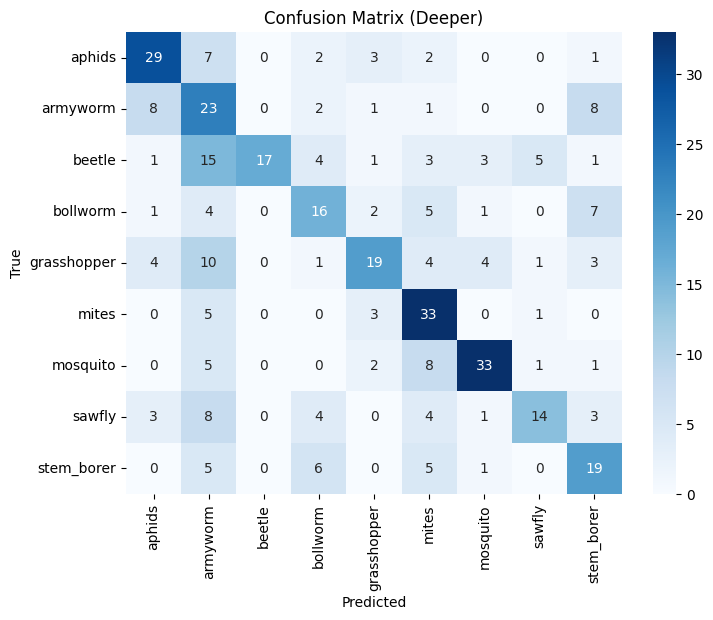

In [34]:
#Predictions
y_pred_deeper = np.argmax(model_deeper.predict(test_gen), axis=1)
print("Classification Report (Deeper):")
print(classification_report(y_true, y_pred_deeper, target_names=class_names))
cm_d = confusion_matrix(y_true, y_pred_deeper)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_d, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix (Deeper)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


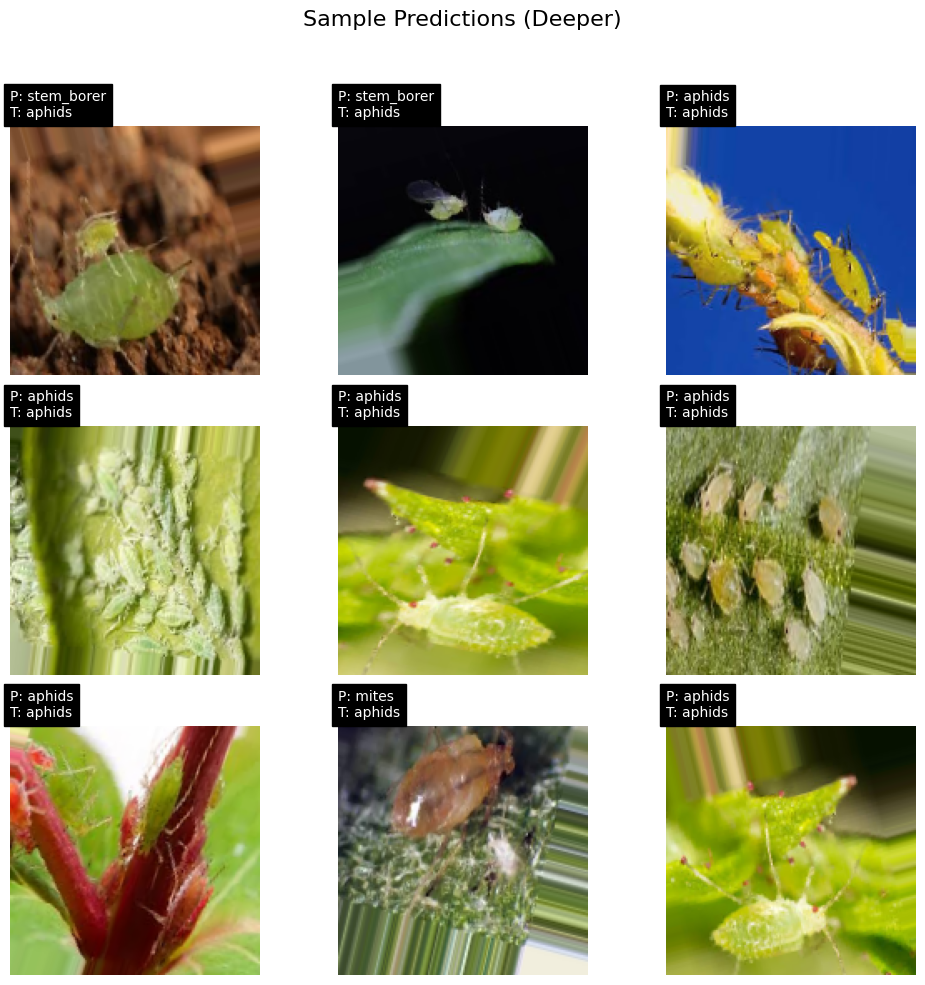

In [35]:
# Sample predictions (Deeper)
y_pred_batch = np.argmax(model_deeper.predict(x_test_batch), axis=1)

# Randomly shuffle indices within the batch to display different images each time
random_indices = np.random.permutation(x_test_batch.shape[0])[:9]  # Select 9 random indices from 0 to 31

plt.figure(figsize=(10, 10))  # Bigger size for better visibility
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_batch[idx])

    pred_label = class_names[y_pred_batch[idx]]
    true_label = class_names[int(y_test_batch[idx])]

    # Use white text on black background for clarity
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10,
              color='white', backgroundcolor='black', loc='left')
    plt.axis('off')

plt.suptitle("Sample Predictions (Deeper)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [36]:
from tensorflow.keras.optimizers import SGD

# Compare optimizers
adam_acc = test_acc_d

# Deeper model with SGD
model_deeper_sgd = build_deeper_cnn()
model_deeper_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
start = time.time()
history_sgd = model_deeper_sgd.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
sgd_time = time.time() - start
_, sgd_acc = model_deeper_sgd.evaluate(test_gen, verbose=0)
print(f"SGD Test Accuracy: {sgd_acc:.4f} (Time: {sgd_time:.1f}s)")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 631ms/step - accuracy: 0.1646 - loss: 3.1932 - val_accuracy: 0.1197 - val_loss: 51.5897 - learning_rate: 0.0100
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step - accuracy: 0.2161 - loss: 2.5250 - val_accuracy: 0.1220 - val_loss: 6.7244 - learning_rate: 0.0100
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - accuracy: 0.2546 - loss: 2.3104 - val_accuracy: 0.1996 - val_loss: 3.5254 - learning_rate: 0.0100
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - accuracy: 0.2637 - loss: 2.3148 - val_accuracy: 0.2616 - val_loss: 2.3720 - learning_rate: 0.0100
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.3141 - loss: 2.1195 - val_accuracy: 0.2594 - val_loss: 2.3738 - learning_rate: 0.0100
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - accuracy: 0.3270 - loss: 2.1259 - val_accuracy: 0.2239 - val_loss: 2.5847 - learning_rate: 0.0100
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.3574 - 

In [37]:
#Report comparision
print(f"Baseline Test Accuracy: {test_acc:.4f}")
print(f"Deeper Model Test Accuracy: {test_acc_d:.4f}")
print(f"SGD Test Accuracy: {sgd_acc:.4f} (Time: {sgd_time:.1f}s)")

Baseline Test Accuracy: 0.4896
Deeper Model Test Accuracy: 0.5208
SGD Test Accuracy: 0.6224 (Time: 1085.3s)


In [38]:
# Summary table
import pandas as pd
results = pd.DataFrame({
    'Model': ['Baseline', 'Deeper (Adam)', 'Deeper (SGD)'],
    'Test Accuracy': [test_acc, adam_acc, sgd_acc]
})
print("\nSummary of Results:")
print(results)


Summary of Results:
           Model  Test Accuracy
0       Baseline       0.489583
1  Deeper (Adam)       0.520833
2   Deeper (SGD)       0.622396


In [39]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input

In [40]:
#Image augmentation and preprocessing for MobileNetV1
mobilenet_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

In [41]:
# Train , validation, and test data generators
train_gen_mobilenet = mobilenet_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

Found 1816 images belonging to 9 classes.


In [42]:
val_gen_mobilenet = mobilenet_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)


Found 451 images belonging to 9 classes.


In [43]:
test_gen_mobilenet = mobilenet_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 384 images belonging to 9 classes.


In [44]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet

def build_mobilenet_frozen():
    # Load MobileNetV1 without the top layer and with pretrained ImageNet weights
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Freeze the base model layers (feature extraction)
    base_model.trainable = False

    # Build custom classifier
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    x = base_model(inputs, training=False)  # Freeze batch normalization layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [45]:
# Build the frozen model
mobilenet_frozen_model = build_mobilenet_frozen()
mobilenet_frozen_model.summary()

<ipython-input-44-7016ecb80226>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,493,577 (13.33 MB)

 Trainable params: 264,713 (1.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [46]:
from tensorflow.keras.optimizers import Adam

mobilenet_frozen_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

mobilenet_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('mobilenet_v1_frozen_best.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]


In [48]:
mobilenet_epochs = 50
import time

start_time = time.time()

history_mobilenet_frozen = mobilenet_frozen_model.fit(
    train_gen_mobilenet,
    validation_data=val_gen_mobilenet,
    epochs=mobilenet_epochs,
    callbacks=mobilenet_callbacks
)

mobilenet_frozen_time = time.time() - start_time


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 34s 486ms/step - accuracy: 0.1552 - loss: 3.5790 - val_accuracy: 0.2661 - val_loss: 2.1141 - learning_rate: 1.0000e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2255 - loss: 2.4504 - val_accuracy: 0.3126 - val_loss: 1.9060 - learning_rate: 1.0000e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 377ms/step - accuracy: 0.3188 - loss: 1.9635 - val_accuracy: 0.3814 - val_loss: 1.7679 - learning_rate: 1.0000e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.3703 - loss: 1.7890 - val_accuracy: 0.3947 - val_loss: 1.6921 - learning_rate: 1.0000e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.4409 - loss: 1.6177 - val_accuracy: 0.4368 - val_loss: 1.6896 - learning_rate: 1.0000e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - accuracy: 0.4444 - loss: 1.5659 - val_accuracy: 0.4324 - val_loss: 1.6141 - learning_rate: 1.0000e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 423ms/step - acc

In [49]:
test_loss_mobilenet_frozen, test_acc_mobilenet_frozen = mobilenet_frozen_model.evaluate(test_gen_mobilenet, verbose=0)
print(f"MobileNetV1 Frozen Test Accuracy: {test_acc_mobilenet_frozen:.4f}")

#Get predictions
y_pred_mobilenet_frozen = np.argmax(mobilenet_frozen_model.predict(test_gen_mobilenet), axis=1)
y_true_mobilenet_frozen = test_gen_mobilenet.classes

MobileNetV1 Frozen Test Accuracy: 0.7188
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step


In [50]:
from sklearn.metrics import classification_report

print("Classification Report (MobileNetV1 Frozen):")
print(classification_report(y_true_mobilenet_frozen, y_pred_mobilenet_frozen, target_names=class_names))


Classification Report (MobileNetV1 Frozen):
              precision    recall  f1-score   support

      aphids       0.62      0.68      0.65        44
    armyworm       0.78      0.65      0.71        43
      beetle       0.67      0.84      0.74        50
    bollworm       0.60      0.78      0.67        36
 grasshopper       0.78      0.87      0.82        46
       mites       0.76      0.69      0.72        42
    mosquito       0.75      0.88      0.81        50
      sawfly       0.59      0.35      0.44        37
  stem_borer       0.85      0.47      0.61        36

    accuracy                           0.71       384
   macro avg       0.71      0.69      0.69       384
weighted avg       0.71      0.71      0.70       384



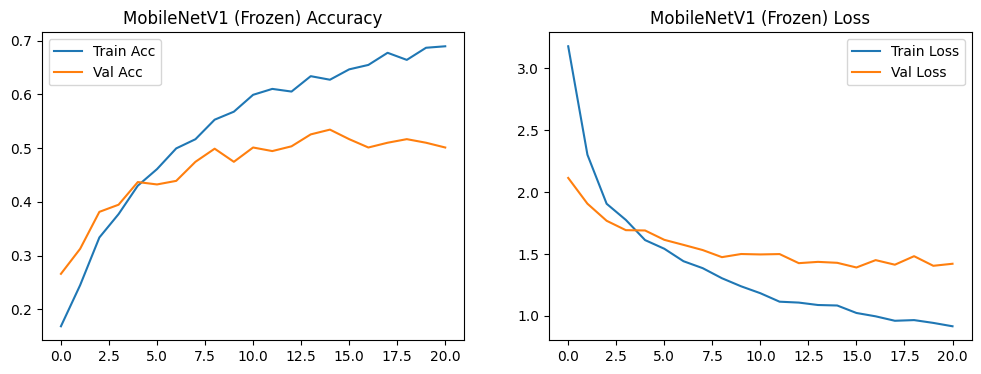

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet_frozen.history['accuracy'], label='Train Acc')
plt.plot(history_mobilenet_frozen.history['val_accuracy'], label='Val Acc')
plt.title("MobileNetV1 (Frozen) Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet_frozen.history['loss'], label='Train Loss')
plt.plot(history_mobilenet_frozen.history['val_loss'], label='Val Loss')
plt.title("MobileNetV1 (Frozen) Loss")
plt.legend()
plt.show()


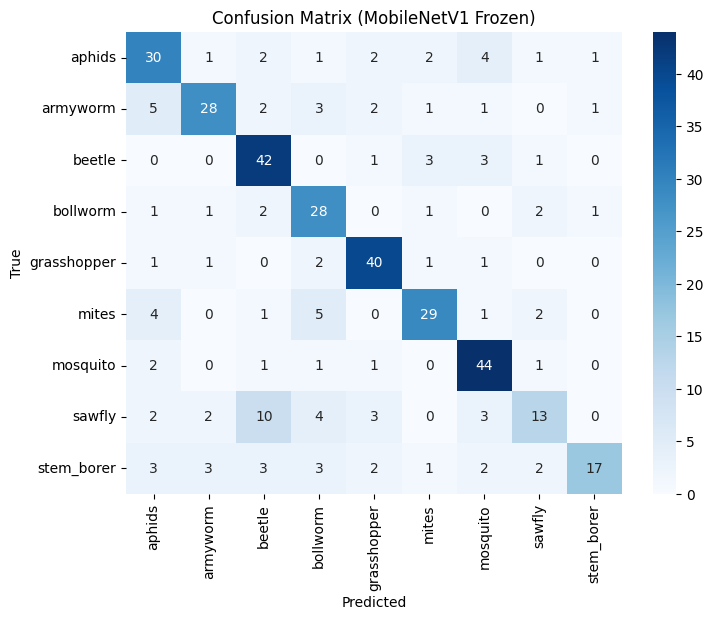

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_mobilenet_frozen = confusion_matrix(y_true_mobilenet_frozen, y_pred_mobilenet_frozen)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mobilenet_frozen, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix (MobileNetV1 Frozen)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


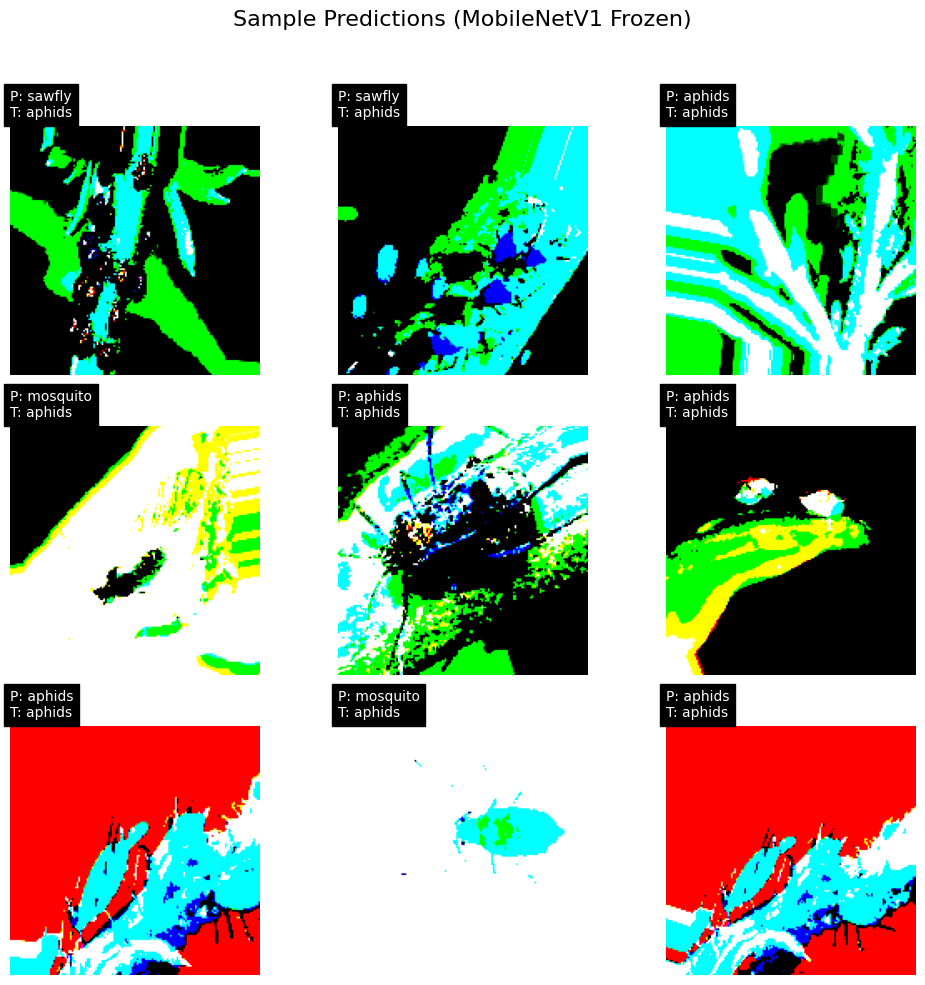

In [53]:
x_test_batch, y_test_batch = next(test_gen_mobilenet)
y_pred_batch_mobilenet = np.argmax(mobilenet_frozen_model.predict(x_test_batch), axis=1)

random_indices = np.random.permutation(x_test_batch.shape[0])[:9]
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_batch[idx])
    pred_label = class_names[y_pred_batch_mobilenet[idx]]
    true_label = class_names[int(y_test_batch[idx])]
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10, color='white', backgroundcolor='black', loc='left')
    plt.axis('off')
plt.suptitle("Sample Predictions (MobileNetV1 Frozen)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [54]:
# Unlock some layers for fine-tuning
base_model = mobilenet_frozen_model.layers[1]  # Extract the base model from frozen model
base_model.trainable = True

# Fine-tune the last few layers (e.g., last 4 layers)
fine_tune_at = len(base_model.layers) - 4
for layer in base_model.layers[-8:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


In [55]:
mobilenet_frozen_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [56]:
mobilenet_finetune_epochs = 50
start_time = time.time()

history_mobilenet_finetuned = mobilenet_frozen_model.fit(
    train_gen_mobilenet,
    validation_data=val_gen_mobilenet,
    epochs=mobilenet_finetune_epochs,
    callbacks=mobilenet_callbacks
)

mobilenet_finetuned_time = time.time() - start_time


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 59s 625ms/step - accuracy: 0.4088 - loss: 1.7501 - val_accuracy: 0.5565 - val_loss: 1.3724 - learning_rate: 1.0000e-05
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 404ms/step - accuracy: 0.4918 - loss: 1.5008 - val_accuracy: 0.5521 - val_loss: 1.3619 - learning_rate: 1.0000e-05
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 377ms/step - accuracy: 0.5227 - loss: 1.3983 - val_accuracy: 0.5876 - val_loss: 1.2787 - learning_rate: 1.0000e-05
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 399ms/step - accuracy: 0.6135 - loss: 1.1738 - val_accuracy: 0.6297 - val_loss: 1.1556 - learning_rate: 1.0000e-05
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.6089 - loss: 1.1179 - val_accuracy: 0.6031 - val_loss: 1.1750 - learning_rate: 1.0000e-05
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 379ms/step - accuracy: 0.6887 - loss: 0.9241 - val_accuracy: 0.6208 - val_loss: 1.1400 - learning_rate: 1.0000e-05
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - acc

In [57]:
test_loss_mobilenet_finetuned, test_acc_mobilenet_finetuned = mobilenet_frozen_model.evaluate(test_gen_mobilenet, verbose=0)
print(f"MobileNetV1 (Fine-Tuned) Test Accuracy: {test_acc_mobilenet_finetuned:.4f}")

# Get predictions
y_pred_mobilenet_finetuned = np.argmax(mobilenet_frozen_model.predict(test_gen_mobilenet), axis=1)
y_true_mobilenet_finetuned = test_gen_mobilenet.classes


MobileNetV1 (Fine-Tuned) Test Accuracy: 0.9036
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step


In [58]:
print("Classification Report (MobileNetV1 Fine-Tuned):")
print(classification_report(y_true_mobilenet_finetuned, y_pred_mobilenet_finetuned, target_names=class_names))


Classification Report (MobileNetV1 Fine-Tuned):
              precision    recall  f1-score   support

      aphids       0.82      0.91      0.86        44
    armyworm       0.90      0.84      0.87        43
      beetle       1.00      0.96      0.98        50
    bollworm       0.81      0.97      0.89        36
 grasshopper       0.98      0.98      0.98        46
       mites       0.95      0.86      0.90        42
    mosquito       0.88      0.98      0.92        50
      sawfly       0.85      0.76      0.80        37
  stem_borer       0.90      0.78      0.84        36

    accuracy                           0.90       384
   macro avg       0.90      0.89      0.89       384
weighted avg       0.90      0.90      0.90       384



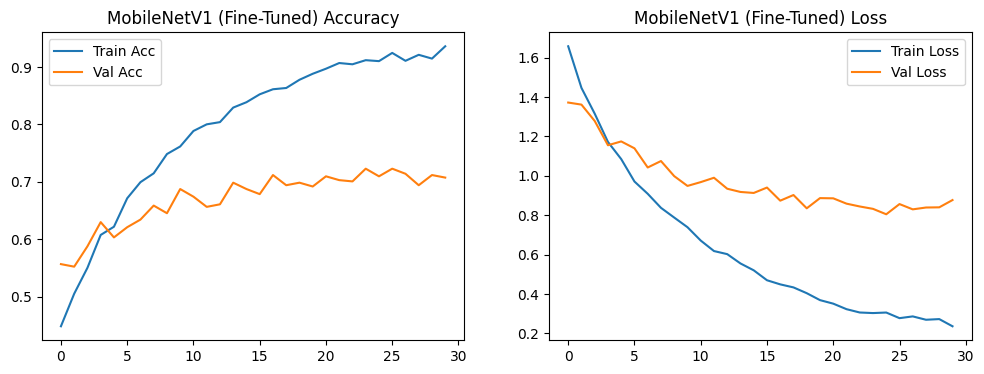

In [59]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet_finetuned.history['accuracy'], label='Train Acc')
plt.plot(history_mobilenet_finetuned.history['val_accuracy'], label='Val Acc')
plt.title("MobileNetV1 (Fine-Tuned) Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet_finetuned.history['loss'], label='Train Loss')
plt.plot(history_mobilenet_finetuned.history['val_loss'], label='Val Loss')
plt.title("MobileNetV1 (Fine-Tuned) Loss")
plt.legend()
plt.show()


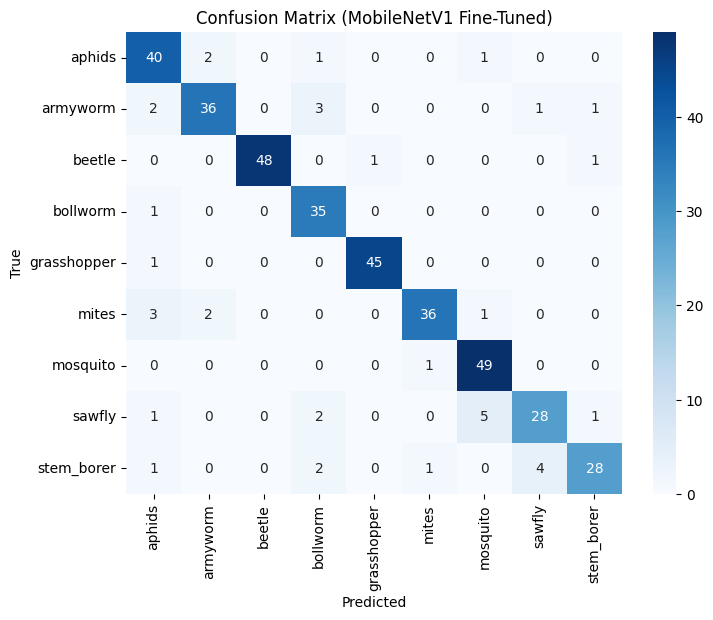

In [60]:
cm_mobilenet_finetuned = confusion_matrix(y_true_mobilenet_finetuned, y_pred_mobilenet_finetuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mobilenet_finetuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix (MobileNetV1 Fine-Tuned)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


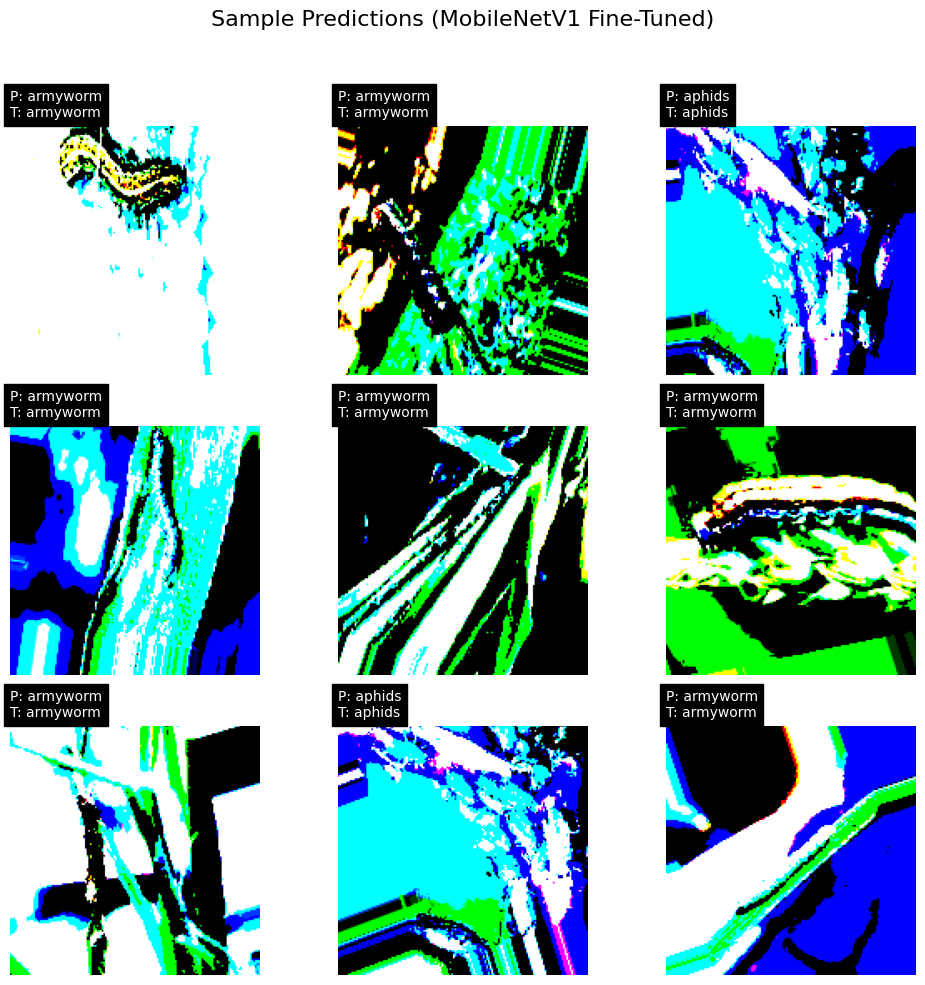

In [61]:
# Get a batch of test data
x_test_batch, y_test_batch = next(test_gen_mobilenet)

# Predict using the fine-tuned model
y_pred_batch_mobilenet_finetuned = np.argmax(mobilenet_frozen_model.predict(x_test_batch), axis=1)

# Select random indices for displaying predictions
random_indices = np.random.permutation(x_test_batch.shape[0])[:9]

# Plotting the images and their predictions
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_batch[idx])  # Display the image
    pred_label = class_names[y_pred_batch_mobilenet_finetuned[idx]]  # Predicted label
    true_label = class_names[int(y_test_batch[idx])]  # True label
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=10, color='white', backgroundcolor='black', loc='left')
    plt.axis('off')

# Set the overall title for the plot
plt.suptitle("Sample Predictions (MobileNetV1 Fine-Tuned)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap
plt.show()


In [62]:
# Print all test accuracies
print(f"{'Model':<30} {'Optimizer':<10} {'Test Accuracy':<15}")
print("-" * 55)
# Baseline model
print(f"{'Baseline CNN':<30} {'Adam':<10} {test_acc:.4f}")

# Deeper CNN with Adam
print(f"{'Deeper CNN':<30} {'Adam':<10} {adam_acc:.4f}")

# Deeper CNN with SGD
print(f"{'Deeper CNN':<30} {'SGD':<10} {sgd_acc:.4f}")

# MobileNetV1 (Frozen)
print(f"{'MobileNetV1 (Frozen)':<30} {'Adam':<10} {test_acc_mobilenet_frozen:.4f}")

# MobileNetV1 (Fine-Tuned)
print(f"{'MobileNetV1 (Fine-Tuned)':<30} {'Adam':<10} {test_acc_mobilenet_finetuned:.4f}")


Model                          Optimizer  Test Accuracy  
-------------------------------------------------------
Baseline CNN                   Adam       0.4896
Deeper CNN                     Adam       0.5208
Deeper CNN                     SGD        0.6224
MobileNetV1 (Frozen)           Adam       0.7188
MobileNetV1 (Fine-Tuned)       Adam       0.9036
